In [1]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

# Define cv strategy 

In [2]:
X = pd.read_pickle("To_update/train_x.pickle")
y = pd.read_pickle("To_update/train_y.pickle")
test = pd.read_pickle("To_update/test.pickle")

In [3]:
X.drop("date_block_num", axis = 1, inplace=True)

In [4]:
X.columns

Index(['shop_id', 'item_id', 'item_category_id',
       'item_block_target_mean_lag_1', 'item_block_target_sum_lag_1',
       'shop_block_target_mean_lag_1', 'shop_block_target_sum_lag_1',
       'item_cat_block_target_mean_lag_1', 'item_cat_block_target_sum_lag_1',
       'target_lag_1', 'price_mean_lag_1', 'item_block_target_mean_lag_2',
       'item_block_target_sum_lag_2', 'shop_block_target_mean_lag_2',
       'shop_block_target_sum_lag_2', 'item_cat_block_target_mean_lag_2',
       'item_cat_block_target_sum_lag_2', 'target_lag_2', 'price_mean_lag_2',
       'item_block_target_mean_lag_3', 'item_block_target_sum_lag_3',
       'shop_block_target_mean_lag_3', 'shop_block_target_sum_lag_3',
       'item_cat_block_target_mean_lag_3', 'item_cat_block_target_sum_lag_3',
       'target_lag_3', 'price_mean_lag_3', 'item_block_target_mean_lag_4',
       'item_block_target_sum_lag_4', 'shop_block_target_mean_lag_4',
       'shop_block_target_sum_lag_4', 'item_cat_block_target_mean_lag_4',

In [5]:
y = y.values.clip(0,20)

In [6]:
test.columns

Index(['shop_id', 'item_id', 'item_category_id',
       'item_block_target_mean_lag_1', 'item_block_target_sum_lag_1',
       'shop_block_target_mean_lag_1', 'shop_block_target_sum_lag_1',
       'item_cat_block_target_mean_lag_1', 'item_cat_block_target_sum_lag_1',
       'target_lag_1', 'price_mean_lag_1', 'item_block_target_mean_lag_2',
       'item_block_target_sum_lag_2', 'shop_block_target_mean_lag_2',
       'shop_block_target_sum_lag_2', 'item_cat_block_target_mean_lag_2',
       'item_cat_block_target_sum_lag_2', 'target_lag_2', 'price_mean_lag_2',
       'item_block_target_mean_lag_3', 'item_block_target_sum_lag_3',
       'shop_block_target_mean_lag_3', 'shop_block_target_sum_lag_3',
       'item_cat_block_target_mean_lag_3', 'item_cat_block_target_sum_lag_3',
       'target_lag_3', 'price_mean_lag_3', 'item_block_target_mean_lag_4',
       'item_block_target_sum_lag_4', 'shop_block_target_mean_lag_4',
       'shop_block_target_sum_lag_4', 'item_cat_block_target_mean_lag_4',

In [ ]:
def get_cv(df, start, end):
    result = []
    for i in range(start, end+1):
        dates = df.date_block_num
        train_idx = np.array(df.loc[dates < i].index)
        val_idx = np.array(df.loc[dates == i].index)
        result.append((train_idx, val_idx))
    return np.array(result)

In [ ]:
cv = get_cv(X, 28, 33)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def root_mean_square_error(truth, pred):
    return sqrt(mean_squared_error(truth, pred))
cv_losses_list = []
n_iteration_list = []
def score(params):
    print("Training with params: ")
    print(params)
    cv_losses = []
    cv_iteration = []
    for (train_idx, val_idx) in cv:
        cv_train = X.loc[train_idx]
        cv_val = X.loc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]
        lgb_model = lgb.train(params, lgb.Dataset(cv_train, label = cv_y_train), 2000,
                              lgb.Dataset(cv_val,label = cv_y_val), verbose_eval = False, 
                              early_stopping_rounds = 100)
        train_pred = lgb_model.predict(cv_train, lgb_model.best_iteration + 1)
        val_pred = lgb_model.predict(cv_val, lgb_model.best_iteration + 1)
        
        val_loss = root_mean_square_error(np.clip(cv_y_val,0,20), np.clip(val_pred,0,20))
        train_loss = root_mean_square_error(np.clip(cv_y_train,0,20), np.clip(train_pred, 0, 20))
        print("Training RMSE: {}. Val RMSE: {}".format(train_loss, val_loss))
        print("Best iteration: {}".format(lgb_model.best_iteration))
        cv_losses.append(val_loss)
        cv_iteration.append(lgb_model.best_iteration)
    print("6 fold results: {}".format(cv_losses))
    cv_losses_list.append(cv_losses)
    n_iteration_list.append(cv_iteration)
    
    mean_cv_loss = np.mean(cv_losses)
    print("Average iterations: {}".format(np.mean(cv_iteration)))
    print("Mean Cross Val RMSE: {}\n".format(mean_cv_loss))
    return {"loss":mean_cv_loss, "status": STATUS_OK}

def optimize(space, seed = 1024, max_evals = 5):
    best = fmin(score, space, algo = tpe.suggest, max_evals = max_evals)
    return best
    
    
space = {
    "subsample": hp.quniform("subsample", 0.7,1,0.1),
    "colsample_bytree": hp.quniform("colsample_bytree",0.7,1,0.1),
    "min_data_in_leaf": hp.choice("min_data_in_leaf",np.arange(10,30,5,dtype=int)),
    "learning_rate": hp.quniform("learning_rate", 0.01,0.3,0.05),
    "seed":1024,
    "objective":"regression",
    "metric":"rmse",
}
best_hyper = optimize(space)

In [8]:
lgb_params = {
               'colsample_bytree': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 128, 
               'subsample': 0.75, 
               'learning_rate': 0.05, 
               'objective': 'regression', 
               'bagging_seed': 128, 
               'num_leaves': 128,
               'bagging_freq':1,
               'seed':1204
}

In [9]:
%%time
lgb_model_full = lgb.train(lgb_params, lgb.Dataset(X, label=y), 708, lgb.Dataset(X, label=y),verbose_eval=10)

[10]	valid_0's rmse: 0.985559
[20]	valid_0's rmse: 0.898888
[30]	valid_0's rmse: 0.854271
[40]	valid_0's rmse: 0.82823
[50]	valid_0's rmse: 0.811613
[60]	valid_0's rmse: 0.800229
[70]	valid_0's rmse: 0.791405
[80]	valid_0's rmse: 0.784555
[90]	valid_0's rmse: 0.777702
[100]	valid_0's rmse: 0.772231
[110]	valid_0's rmse: 0.767573
[120]	valid_0's rmse: 0.763251
[130]	valid_0's rmse: 0.759725
[140]	valid_0's rmse: 0.756676
[150]	valid_0's rmse: 0.753703
[160]	valid_0's rmse: 0.751054
[170]	valid_0's rmse: 0.748678
[180]	valid_0's rmse: 0.74672
[190]	valid_0's rmse: 0.744647
[200]	valid_0's rmse: 0.742678
[210]	valid_0's rmse: 0.740659
[220]	valid_0's rmse: 0.739107
[230]	valid_0's rmse: 0.737433
[240]	valid_0's rmse: 0.735967
[250]	valid_0's rmse: 0.734467
[260]	valid_0's rmse: 0.732727
[270]	valid_0's rmse: 0.731314
[280]	valid_0's rmse: 0.730126
[290]	valid_0's rmse: 0.728799
[300]	valid_0's rmse: 0.727513
[310]	valid_0's rmse: 0.726442
[320]	valid_0's rmse: 0.725425
[330]	valid_0's rms

In [ ]:
X.columns

In [ ]:
X.to_pickle("train.pickle")

In [ ]:
y

In [31]:
train_pred = lgb_model_full.predict(X)

In [ ]:
len(train_pred)

In [ ]:
y[y > 20]

In [ ]:
train_pred

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def root_mean_square_error(truth, pred):
    return sqrt(mean_squared_error(truth, pred))
print(root_mean_square_error(np.clip(y,0,20), np.clip(train_pred,0,20)))

In [10]:
test_pred = lgb_model_full.predict(test)
test_pred

array([ 0.00541137,  0.11554425,  0.2433814 , ..., -0.02974593,
       -0.04109116, -0.02431632])

In [11]:
test_pred[:5]

array([ 0.00541137,  0.11554425,  0.2433814 ,  0.11305329,  0.02368818])

In [13]:
sample = pd.read_csv("../sample_submission.csv")
sample

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
5,5,0.5
6,6,0.5
7,7,0.5
8,8,0.5
9,9,0.5


In [14]:
test_pred = np.clip(test_pred, 0, 20)
sample["item_cnt_month"] = test_pred

In [15]:
sub = sample

sub.head(120)

,ID,item_cnt_month
0,0,0.237400
1,1,0.149007
2,2,0.639027
3,3,0.185024
4,4,0.242572
5,5,0.417214
6,6,0.416380
7,7,0.088367
8,8,0.793085
9,9,0.063143


In [ ]:
sub.to_csv("submission/submission_lightgbm_new.csv", index=False)

In [ ]:
test_pred.mean()

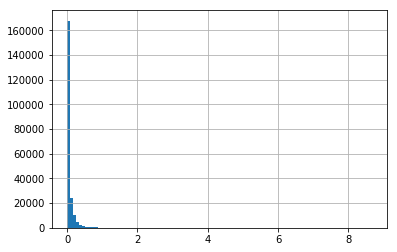

In [15]:
test_pred = test_pred.clip(0,20)
pd.Series(test_pred).hist(bins=100)

In [ ]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission/submission_lightgbm_new.csv -m "Message"


In [36]:
train_pred.shape

(6639294,)

In [43]:
train_pred

array([  1.40999063,   1.03288627,  12.69536033, ...,   0.01505886,
         0.01269941,   0.01302484])